## Model Concept

This recommender system includes two parts: (1) Retrieval, and (2) Ranking. The retrieval stage is responsible to select an initial subset of possible candidates from the large datasets. Then, the ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations.

The retrieval model ensure the recommender system is computationally efficient, as sometimes they could be a large set of items on the shelf. Also, the ranking model is used to predict the user rating on the relevant product.

## Data Preprocessing

In [1]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval
from collections import Counter
from typing import Dict, Text
import random

In [2]:
credits = pd.read_csv("movies/credits.csv")
keywords = pd.read_csv("movies/keywords.csv")
movies = pd.read_csv("movies/movies_metadata.csv").drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).drop([19730, 29503, 35587])
ratings = pd.read_csv("movies/ratings_small.csv")

movies['id'] = movies['id'].astype('int64')

C:\Users\Terry Chong\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [4]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [5]:
df = movies.merge(keywords, on='id').merge(credits, on='id')
df

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46623,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Rising and falling between a man and woman,4.0,1.0,"[{'id': 10703, 'name': 'tragic love'}]","[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de..."
46624,False,0,"[{'id': 18, 'name': 'Drama'}]",111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",NaN,9.0,3.0,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,...","[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de..."
46625,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'i

In [6]:
df.isnull().sum()

adult                       0
budget                      0
genres                      0
id                          0
original_language          11
original_title              0
overview                  995
popularity                  4
production_companies        4
production_countries        4
release_date               88
revenue                     4
runtime                   268
spoken_languages            4
tagline                 25845
vote_average                4
vote_count                  4
keywords                    0
cast                        0
crew                        0
dtype: int64

In [7]:
df = df.drop('tagline', axis=1)
df = df.dropna()
df

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46622,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",30840,en,Robin Hood,"Yet another version of the classic epic, with ...",5.683753,"[{'name': 'Westdeutscher Rundfunk (WDR)', 'id'...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1991-05-13,0.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",5.7,26.0,[],"[{'cast_id': 1, 'character': 'Sir Robert Hode'...","[{'credit_id': '52fe44439251416c9100a899', 'de..."
46624,False,0,"[{'id': 18, 'name': 'Drama'}]",111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",9.0,3.0,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,...","[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de..."
46625,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",3.8,6.0,[],"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4

In [8]:
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
        
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)


In [9]:
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)
df['actor'] = df['cast'].apply(get_text)
df['characters'] = df['cast'].apply(get_text, obj='character')
df['crew'] = df['crew'].apply(get_text)
df = df.drop('cast', axis=1)
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')
df = df.drop_duplicates(subset=['original_title'])
df = df.reset_index(drop=True)

In [10]:
df

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,actor,characters
0,False,30000000.0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,English,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...","Woody (voice), Buzz Lightyear (voice), Mr. Pot..."
1,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,262797249.0,104.0,"English, Français",6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ..."
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...","Max Goldman, John Gustafson, Ariel Gustafson, ..."
3,False,16000000.0,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,English,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Whitney Houston, Angela Bassett, Loretta Devin...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ..."
4,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,1995-02-10,76578911.0,106.0,English,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","Steve Martin, Diane Keaton, Martin Short, Kimb...","George Banks, Nina Banks, Franck Eggelhoffer, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42358,False,0.0,Horror,289923,en,The Burkittsville 7,A film archivist revisits the story of Rustin ...,0.386450,"Neptune Salad Entertainment, Pirie Productions",United States of America,2000-10-03,0.0,30.0,English,7.0,1.0,"witch, mythology, legend, serial killer, mocku...","Ben Rock, Ben Rock","Monty Bane, Lucy Butler, David Grammer, Bill D...","Branwall, Sarah Didonna, Kyle Brody, Bill Barn..."
42359,False,0.0,Science Fiction,222848,en,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,0.661558,Concorde-New Horizons,United States of America,1995-01-01,0.0,85.0,English,3.5,1.0,,"Roger Corman, Mike Elliott, Aaron Osborne, Mik...","Lisa Boyle, Kena Land, Zaneta Polard, Don Yana...","Kira (as Cassandra Leigh), Daly, Ruggs, Lewis,..."
42360,False,0.0,Drama,111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,Sine Olivia,Philippines,2011-11-17,0.0,360.0,,9.0,3.0,"artist, play, pinoy","Lav Diaz, Lav Diaz, Dante Perez, Lav Diaz, Lav...","Angel Aquino, Perry Dizon, Hazel Orencio, Joel...","Sister Angela, Homer, Crazy Woman/Virgin, Aman..."
42361,False,0.0,,227506,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,Yermoliev,Russia,1917-10-21,0.0,87.0,,0.0,0.0,,"Yakov Protazanov, Joseph N. Ermolieff","Iwan Mosschuchin, Nathalie Lissenko, Pavel Pav...",", , , ,"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 42363 non-null  object        
 1   budget                42363 non-null  float64       
 2   genres                42363 non-null  object        
 3   id                    42363 non-null  int64         
 4   original_language     42363 non-null  object        
 5   original_title        42363 non-null  object        
 6   overview              42363 non-null  object        
 7   popularity            42363 non-null  float64       
 8   production_companies  42363 non-null  object        
 9   production_countries  42363 non-null  object        
 10  release_date          42363 non-null  datetime64[ns]
 11  revenue               42363 non-null  float64       
 12  runtime               42363 non-null  float64       
 13  spoken_languages

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,42363.0,4.191992e+06,1.723974e+07,0.0,0.000000,0.00000,0.000000,3.800000e+08
id,42363.0,1.059049e+05,1.113202e+05,2.0,25647.500000,57701.00000,150027.000000,4.691720e+05
popularity,42363.0,2.943373e+00,5.752899e+00,0.0,0.404918,1.16106,3.784747,5.474883e+02
revenue,42363.0,1.119117e+07,6.377497e+07,0.0,0.000000,0.00000,0.000000,2.787965e+09
runtime,42363.0,9.475918e+01,3.680806e+01,0.0,85.000000,95.00000,107.000000,1.256000e+03
vote_average,42363.0,5.654687e+00,1.890174e+00,0.0,5.000000,6.00000,6.800000,1.000000e+01
vote_count,42363.0,1.100309e+02,4.897686e+02,0.0,3.000000,10.00000,35.000000,1.407500e+04


1. More than 75% of the movies have 0 budget and revenue. We might have to drop these columns since they are not useful to our analysis.
2. Vote are recorded in range [0, 10].
3. Maximum runtime is up to 1256 minutes.

## Correlation Matrix

<AxesSubplot:>

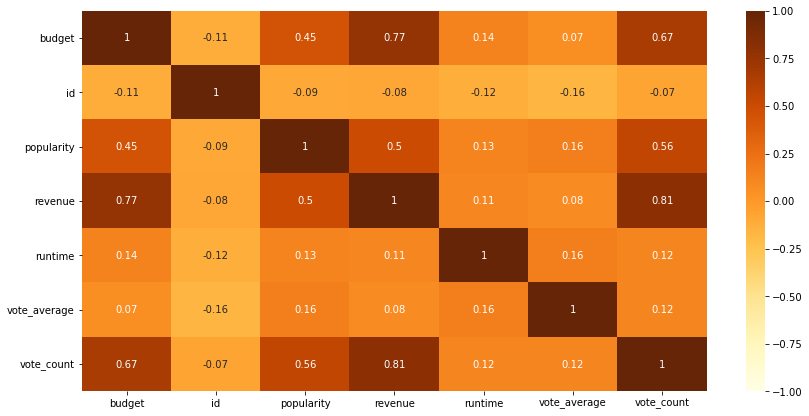

In [13]:
fig, ax = plt.subplots(figsize = (14,7))
corr = df.corr().round(2)
sns.heatmap(corr, annot = True, ax=ax, vmin=-1, vmax=1, center=0, cmap='YlOrBr')

1. We observe a strong relationship between revenue and vote_count.
2. We observe a strong relationship between budget and vote_count.
3. We observe a strong relationship between budget and revenue.

## Univeriate Analysis

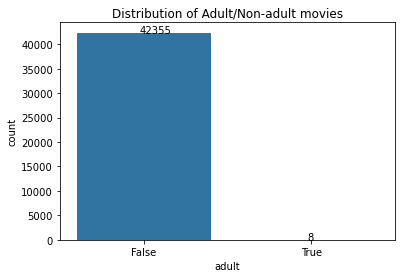

In [14]:
ax = sns.countplot(data=df, x='adult')

for p, label in zip(ax.patches, df['adult'].value_counts()):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+10))
    ax.set_title("Distribution of Adult/Non-adult movies")

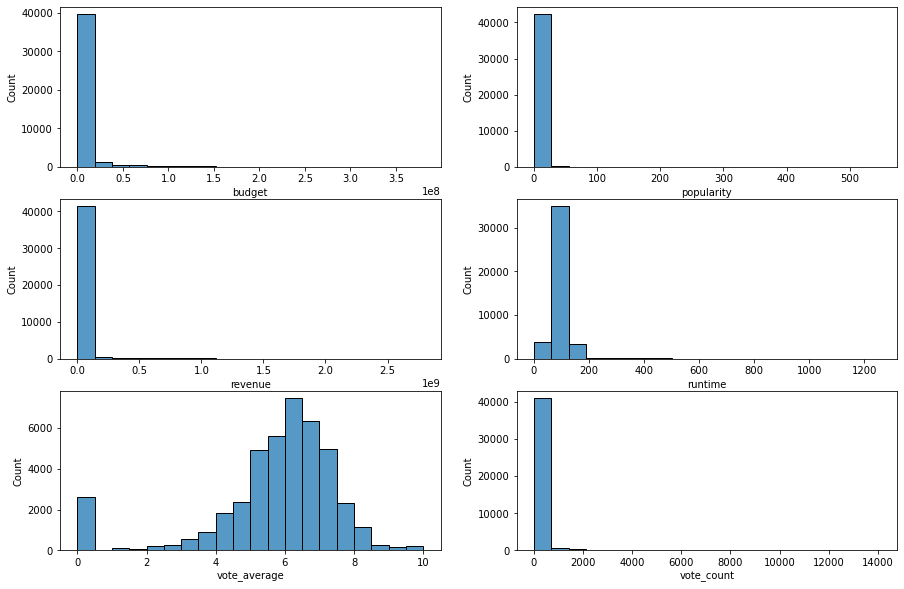

In [15]:
num_col = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

plt.subplots(3, 2, figsize=(15,10))
# Plot histogram
for col in num_col:
    i = num_col.index(col)
    plt.subplot(3, 2, i+1)
    sns.histplot(data=df,x=col, bins=20)

We observe right skewed for most of the numeric variables

**Most popular movies**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Minions'),
  Text(1, 0, 'Baby Driver'),
  Text(2, 0, 'Big Hero 6'),
  Text(3, 0, 'Deadpool'),
  Text(4, 0, 'Guardians of the Galaxy Vol. 2'),
  Text(5, 0, 'Avatar'),
  Text(6, 0, 'John Wick'),
  Text(7, 0, 'Gone Girl'),
  Text(8, 0, 'The Hunger Games: Mockingjay - Part 1'),
  Text(9, 0, 'War for the Planet of the Apes')])

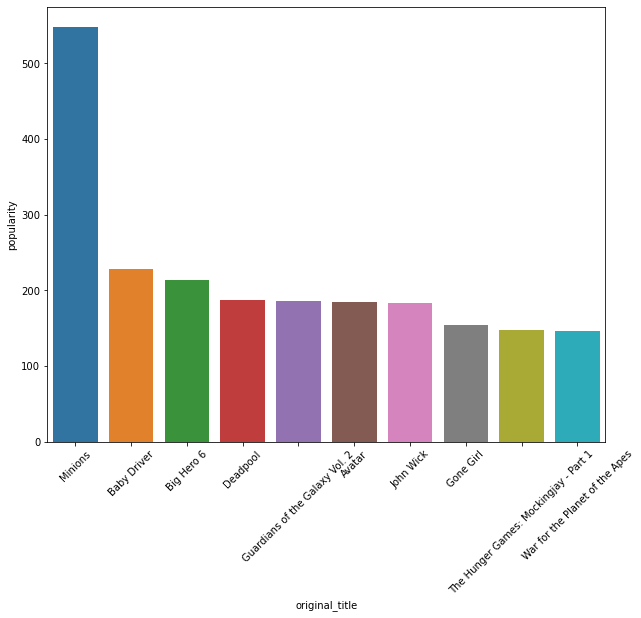

In [16]:
popular = df.sort_values(by='popularity', ascending=False).head(10)

plt.figure(figsize=(10,8))
sns.barplot(data=popular, x= 'original_title', y='popularity')
plt.xticks(rotation=45)

**Most popular genres**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Romance'),
  Text(4, 0, 'Action'),
  Text(5, 0, 'Horror'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Documentary'),
  Text(8, 0, 'Adventure'),
  Text(9, 0, 'Science Fiction')])

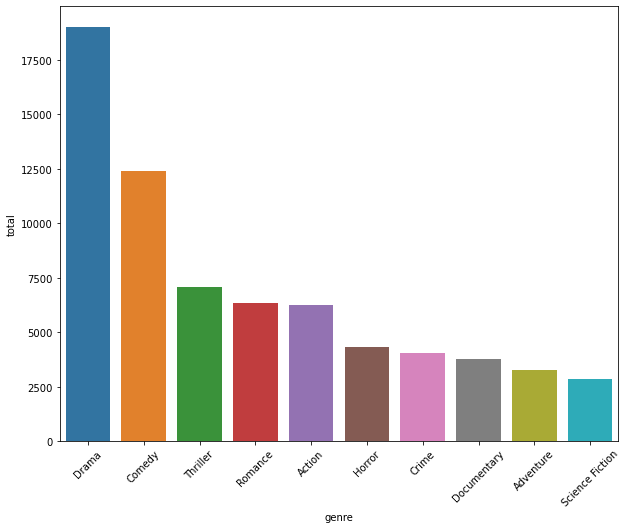

In [17]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

genres = pd.DataFrame(Counter(genres_list).most_common(10), columns=['genre', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=genres, x='genre', y='total')
plt.xticks(rotation=45)

**Most popular actors**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Bess Flowers'),
  Text(1, 0, 'Christopher Lee'),
  Text(2, 0, 'John Wayne'),
  Text(3, 0, 'Samuel L. Jackson'),
  Text(4, 0, 'Jackie Chan'),
  Text(5, 0, 'Gérard Depardieu'),
  Text(6, 0, 'Frank Welker'),
  Text(7, 0, 'John Carradine'),
  Text(8, 0, 'Donald Sutherland'),
  Text(9, 0, 'Robert De Niro')])

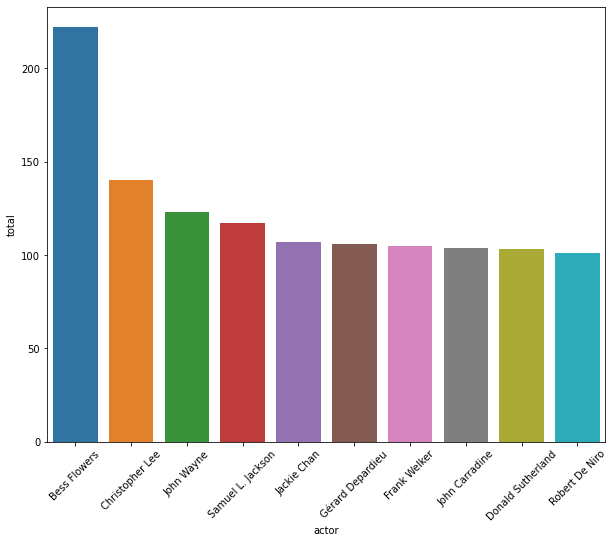

In [18]:
actors_list = []
for i in df['actor']:
    actors_list.extend(i.split(', '))

actors_list = [x for x in actors_list if not x == 'Jr.' and not x == '']

    
actors = pd.DataFrame(Counter(actors_list).most_common(10), columns=['actor', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=actors, x='actor', y='total')
plt.xticks(rotation=45)

**Most popular characters in movies**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Doctor'),
  Text(1, 0, 'Dancer'),
  Text(2, 0, 'himself'),
  Text(3, 0, 'Narrator'),
  Text(4, 0, 'Reporter'),
  Text(5, 0, 'Nurse'),
  Text(6, 0, '(uncredited)'),
  Text(7, 0, 'Anna'),
  Text(8, 0, 'Paul'),
  Text(9, 0, 'Sam')])

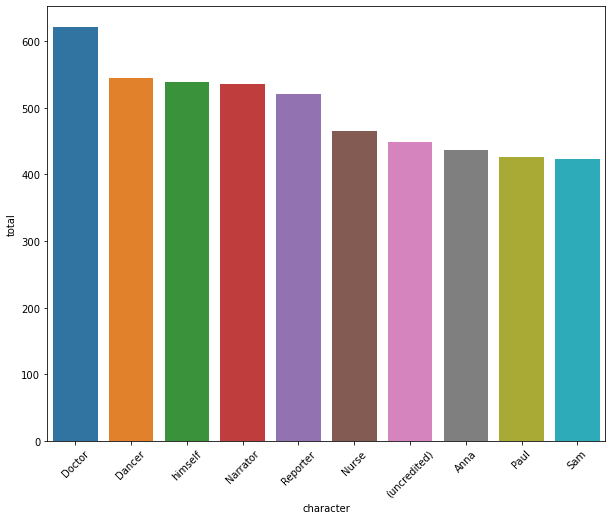

In [19]:
characters_list = []
for i in df['characters']:
    characters_list.extend(i.split(', '))

characters_list = [x for x in characters_list if not x == '' and not x == 'Himself' and not x == 'Herself']

    
characters = pd.DataFrame(Counter(characters_list).most_common(10), columns=['character', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=characters, x='character', y='total')
plt.xticks(rotation=45)

**Most popular keywords in movies**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'woman director'),
  Text(1, 0, 'independent film'),
  Text(2, 0, 'murder'),
  Text(3, 0, 'based on novel'),
  Text(4, 0, 'musical'),
  Text(5, 0, 'sex'),
  Text(6, 0, 'violence'),
  Text(7, 0, 'nudity'),
  Text(8, 0, 'biography'),
  Text(9, 0, 'revenge')])

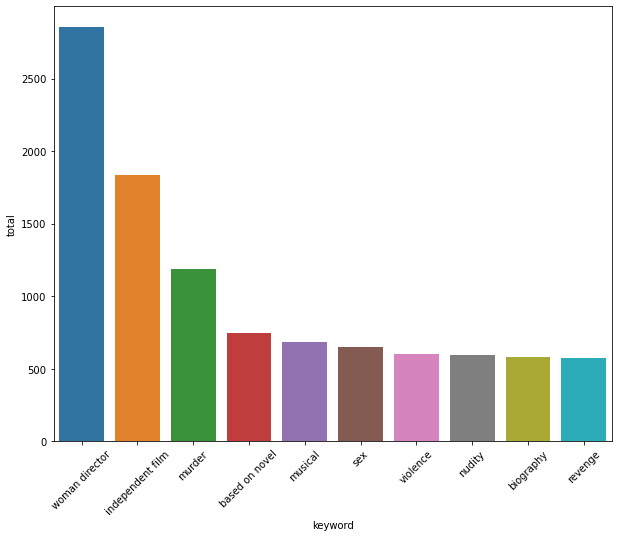

In [20]:
keywords_list = []
for i in df['keywords']:
    keywords_list.extend(i.split(', '))

keywords_list = [x for x in keywords_list if not x == '']

    
keywords = pd.DataFrame(Counter(keywords_list).most_common(10), columns=['keyword', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=keywords, x='keyword', y='total')
plt.xticks(rotation=45)

**Most popular movie production companies**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Warner Bros.'),
  Text(1, 0, 'Metro-Goldwyn-Mayer (MGM)'),
  Text(2, 0, 'Paramount Pictures'),
  Text(3, 0, 'Universal Pictures'),
  Text(4, 0, 'Twentieth Century Fox Film Corporation'),
  Text(5, 0, 'Columbia Pictures Corporation'),
  Text(6, 0, 'Canal+'),
  Text(7, 0, 'Columbia Pictures'),
  Text(8, 0, 'RKO Radio Pictures'),
  Text(9, 0, 'United Artists')])

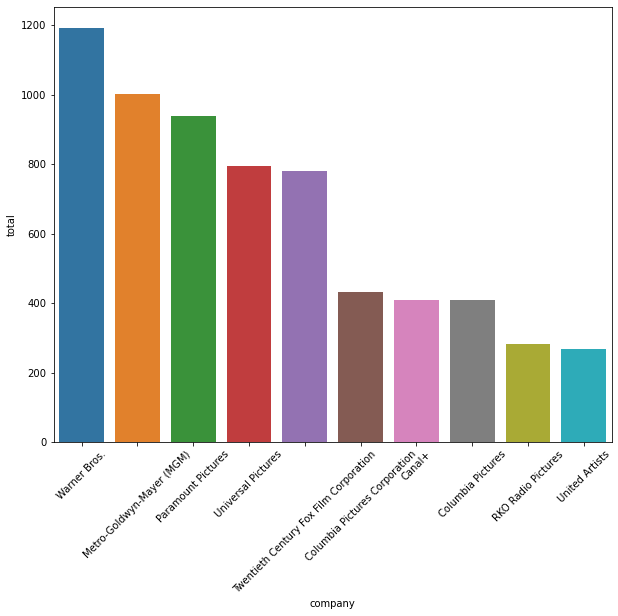

In [21]:
companies_list = []
for i in df['production_companies']:
    companies_list.extend(i.split(', '))

companies_list = [x for x in companies_list if not x == '']

    
companies = pd.DataFrame(Counter(companies_list).most_common(10), columns=['company', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=companies, x='company', y='total')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Total Released Movies by Date')

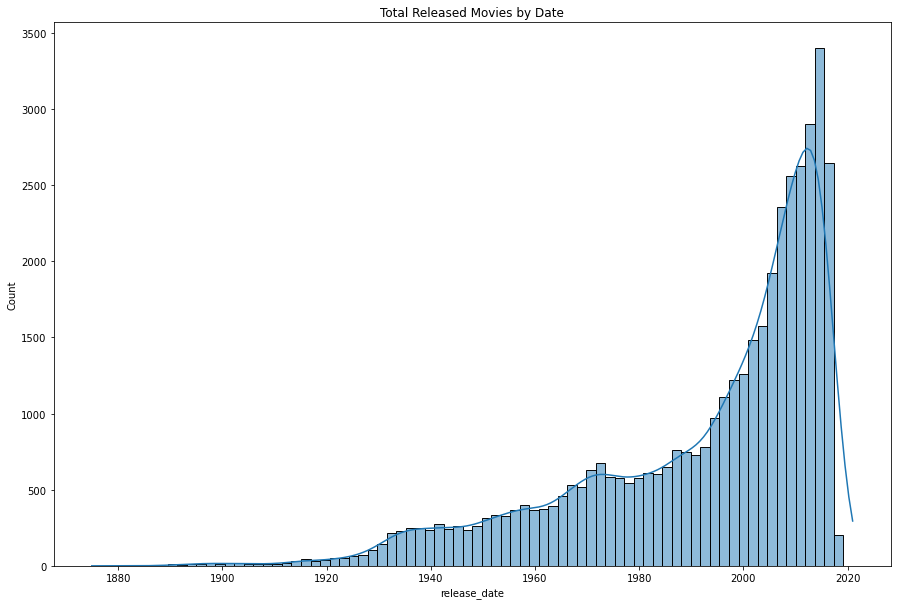

In [22]:
plt.figure(figsize=(15,10))
ax = sns.histplot(data=df, x='release_date', kde='True')
plt.title('Total Released Movies by Date')

## Bivariate Analysis

Text(0.5, 1.0, 'Relationship between revenues and budgets for movies')

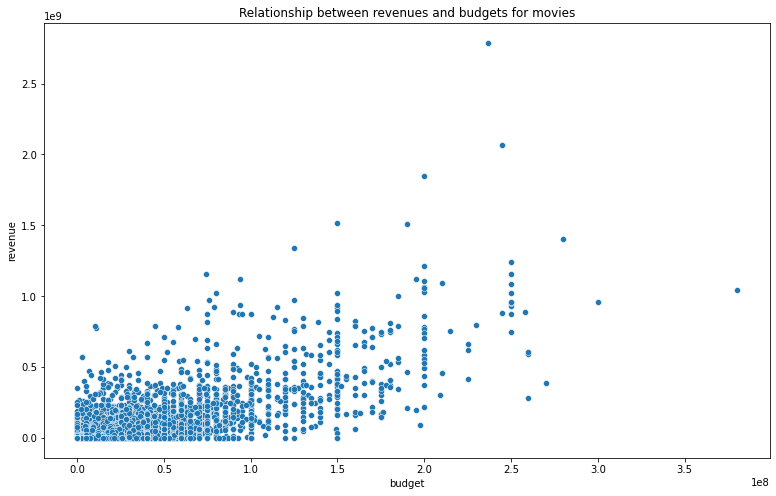

In [23]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='budget', y='revenue')
plt.title('Relationship between revenues and budgets for movies')

Text(0.5, 1.0, 'Relationship between revenues, budgets, and vote counts for movies')

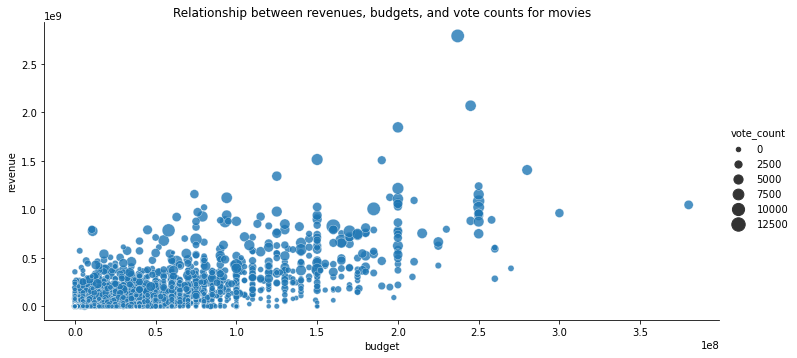

In [24]:
#plt.figure(figsize=(13,8))
sns.relplot(data=df, x='budget', y='revenue', size='vote_count', sizes=(20,200), alpha=0.8, aspect=2)
plt.title('Relationship between revenues, budgets, and vote counts for movies')

Text(0.5, 1.0, 'Relationship between budgets and vote_counts for movies')

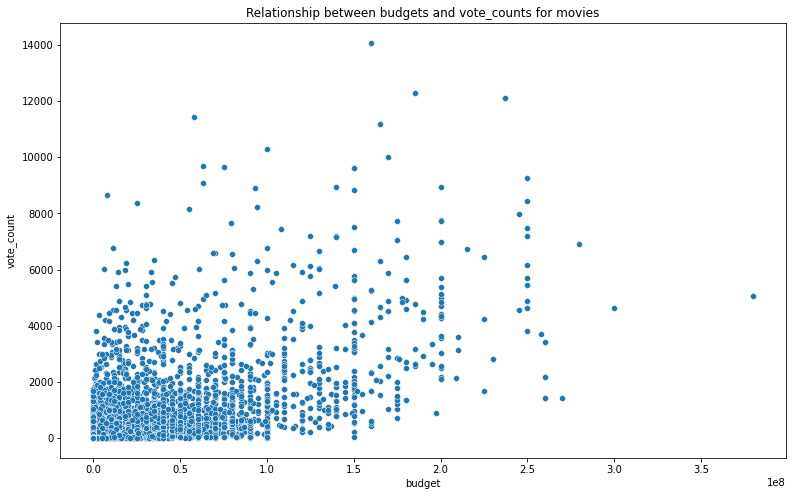

In [25]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='budget', y='vote_count')
plt.title('Relationship between budgets and vote_counts for movies')

Text(0.5, 1.0, 'Relationship between revenues and vote_counts for movies')

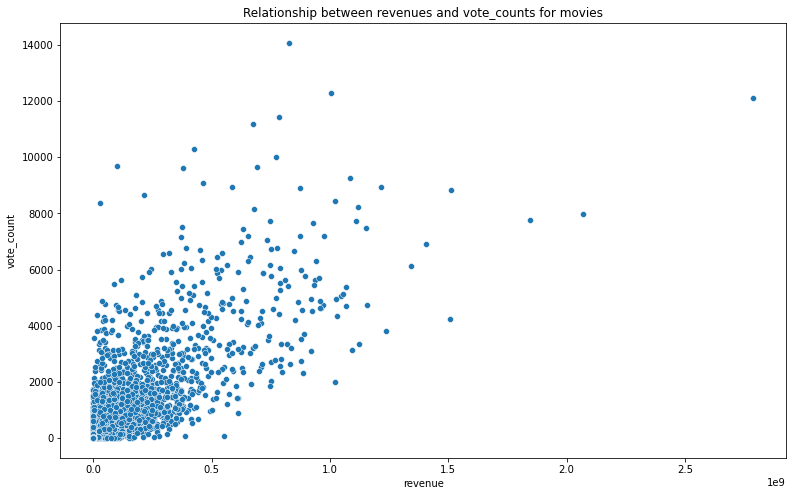

In [26]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='revenue', y='vote_count')
plt.title('Relationship between revenues and vote_counts for movies')

Text(0.5, 1.0, 'Relationship between runtime and popularity for movies')

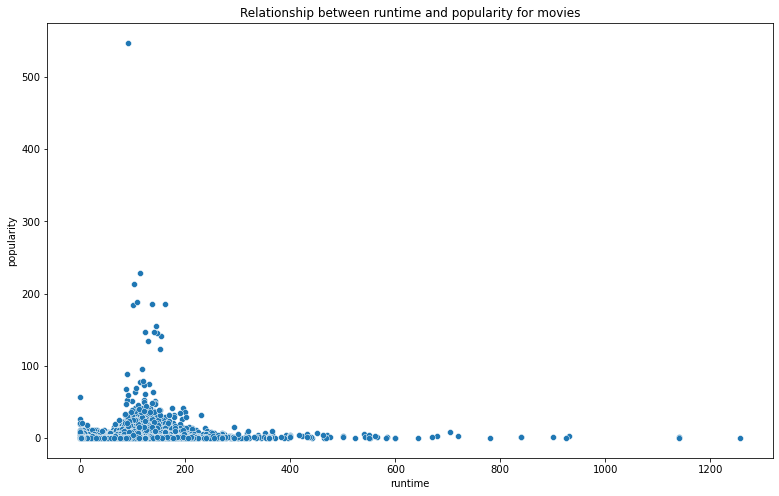

In [27]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='runtime', y='popularity')
plt.title('Relationship between runtime and popularity for movies')

It looks like the more popular movies sit around 150-200 minutes runtime

Text(0.5, 1.0, 'Relationship between revenues and budgets for movies')

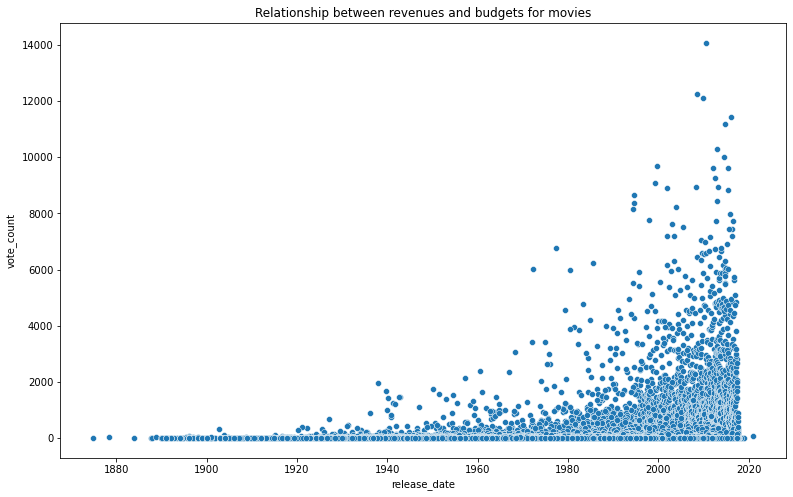

In [28]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='release_date', y='vote_count')
plt.title('Relationship between revenues and budgets for movies')

There are more vote counts for recent released movies. These are normal because more users are using internet and the movie rating system online.

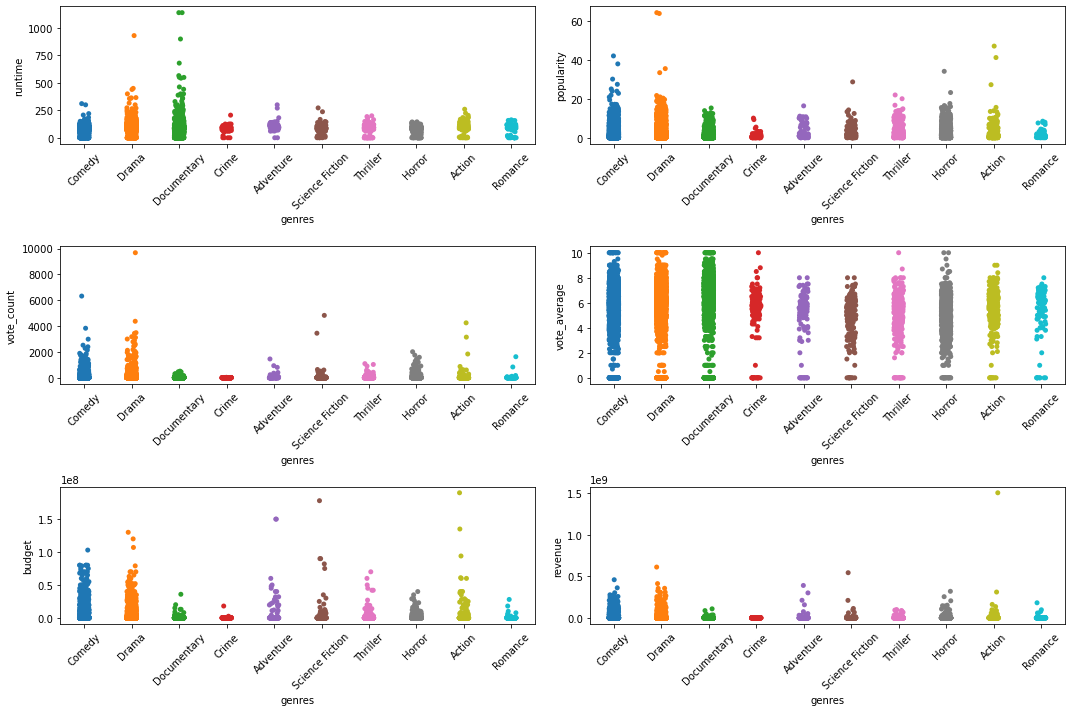

In [29]:
genres = pd.DataFrame(Counter(genres_list).most_common(10), columns=['genre', 'total'])
genres = df[df['genres'].isin(genres['genre'].to_numpy())]

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

for i , y in enumerate(['runtime', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue']):

    sns.stripplot(data=genres, x='genres', y=y, ax=ax.flatten()[i])

    for tick in ax.flatten()[i].get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()

1. Documentary has longer runtime, but with lower vote_count and lower budget and revenue.
2. Overall, we can see Comedy and Drama are the genres that are more welcomed for audience.
3. One action movie generated very high revenue.

In [30]:
df[df.revenue == df.revenue.max()]

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,actor,characters
14067,False,237000000.0,"Action, Adventure, Fantasy, Science Fiction",19995,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",185.070892,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2.787965e+09,162.0,"English, Español",7.2,12114.0,"culture clash, future, space war, space colony...","Stephen E. Rivkin, Rick Carter, Christopher Bo...","Sam Worthington, Zoe Saldana, Sigourney Weaver...","Jake Sully, Princess Neytiri, Dr. Grace August..."


It's Avatar!

## Recommender System

In [31]:
# Preprocess ratings dataFrame
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [32]:
ratings['date'] = ratings['timestamp'].apply(lambda x: pd.datetime.fromtimestamp(x))
ratings.drop('timestamp', axis=1, inplace=True)

ratings

<ipython-input-32-24a0f0b7e350>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ratings['date'] = ratings['timestamp'].apply(lambda x: pd.datetime.fromtimestamp(x))


,userId,movieId,rating,date
0,1,31,2.5,2009-12-13 20:52:24
1,1,1029,3.0,2009-12-13 20:52:59
2,1,1061,3.0,2009-12-13 20:53:02
3,1,1129,2.0,2009-12-13 20:53:05
4,1,1172,4.0,2009-12-13 20:53:25
...,...,...,...,...
99999,671,6268,2.5,2003-10-07 21:16:10
100000,671,6269,4.0,2003-10-02 21:46:41
100001,671,6365,4.0,2003-12-08 21:26:03
100002,671,6385,2.5,2003-12-09 08:21:03


In [33]:
ratings = ratings.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId', right_on='id', how='left')
ratings = ratings.dropna().reset_index(drop=True)
ratings['userId'] = ratings['userId'].astype(str)
ratings_copy = ratings

print(ratings.shape)
ratings.head()

(43188, 8)


,userId,movieId,rating,date,id,original_title,genres,overview
0,1,1371,2.5,2009-12-13 20:52:15,1371.0,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-13 20:53:23,1405.0,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-13 20:52:19,2105.0,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-13 20:53:18,2193.0,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-13 20:51:48,2294.0,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [34]:
movies = df[['id', 'original_title']].rename(columns={'id': 'movieId'})

print(movies.shape)
movies.head()

(42363, 2)


,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [35]:
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [36]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(len(ratings), seed=42, reshuffle_each_iteration=False)

train = shuffled.take(int(len(ratings)*0.8))
val = shuffled.skip(int(len(ratings)*0.8)).take(int(len(ratings)*0.1))
test = shuffled.skip(int(len(ratings)*0.9)).take(int(len(ratings)*0.1))

cached_train = train.shuffle(len(ratings)).batch(1024)
cached_val = val.batch(1024).cache()
cached_test = test.batch(1024).cache()

Total Data: 43188


In [37]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["userId"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

### Retrieval model

In [38]:
# Define user and movie models.
embedding_dimension = 32

user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), embedding_dimension)
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), embedding_dimension)
])

# Define your objectives.
retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
    )
)

# Define callbacks
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10)

In [39]:
class RetrievalModel(tfrs.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()    
        self.user_model: tf.keras.Model = user_model
        self.movie_model: tf.keras.Model = movie_model
        self.retrieval_task: tf.keras.layers.Layer = retrieval_task
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor: 
        
        #Define how the loss is computed  
        user_embeddings = self.user_model(features["userId"])
        movie_embeddings = self.movie_model(features["original_title"])
       
        return self.retrieval_task(user_embeddings, movie_embeddings)
        

In [40]:
# Create a retrieval model
retrieval_model = RetrievalModel(user_model, movie_model)
retrieval_model.compile(optimizer=tf.keras.optimizers.Adam(0.001))

# Train for 10 epochs.
retrieval_model.fit(
    cached_train,
    callbacks=callbacks,
    epochs=20)

Epoch 1/20
34/34 [==============================] - 118s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 2.8944e-05 - factorized_top_k/top_50_categorical_accuracy: 9.8408e-04 - factorized_top_k/top_100_categorical_accuracy: 0.0026 - loss: 6979.5138 - regularization_loss: 0.0000e+00 - total_loss: 6979.5138
Epoch 2/20
34/34 [==============================] - 95s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 5.7887e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0016 - factorized_top_k/top_50_categorical_accuracy: 0.0065 - factorized_top_k/top_100_categorical_accuracy: 0.0108 - loss: 6977.5680 - regularization_loss: 0.0000e+00 - total_loss: 6977.5680
Epoch 3/20
34/34 [==============================] - 95s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_

Epoch 8/20
34/34 [==============================] - 94s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0431 - factorized_top_k/top_10_categorical_accuracy: 0.0823 - factorized_top_k/top_50_categorical_accuracy: 0.2765 - factorized_top_k/top_100_categorical_accuracy: 0.4066 - loss: 6866.7890 - regularization_loss: 0.0000e+00 - total_loss: 6866.7890
Epoch 9/20
34/34 [==============================] - 95s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0423 - factorized_top_k/top_10_categorical_accuracy: 0.0812 - factorized_top_k/top_50_categorical_accuracy: 0.2737 - factorized_top_k/top_100_categorical_accuracy: 0.4037 - loss: 6816.9388 - regularization_loss: 0.0000e+00 - total_loss: 6816.9388
Epoch 10/20
34/34 [==============================] - 133s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_acc

Epoch 15/20
34/34 [==============================] - 104s 3s/step - factorized_top_k/top_1_categorical_accuracy: 2.8944e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0416 - factorized_top_k/top_10_categorical_accuracy: 0.0816 - factorized_top_k/top_50_categorical_accuracy: 0.2753 - factorized_top_k/top_100_categorical_accuracy: 0.4075 - loss: 6519.7190 - regularization_loss: 0.0000e+00 - total_loss: 6519.7190
Epoch 16/20
34/34 [==============================] - 105s 3s/step - factorized_top_k/top_1_categorical_accuracy: 2.0260e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0426 - factorized_top_k/top_10_categorical_accuracy: 0.0828 - factorized_top_k/top_50_categorical_accuracy: 0.2786 - factorized_top_k/top_100_categorical_accuracy: 0.4111 - loss: 6479.1734 - regularization_loss: 0.0000e+00 - total_loss: 6479.1734
Epoch 17/20
34/34 [==============================] - 123s 4s/step - factorized_top_k/top_1_categorical_accuracy: 3.1838e-04 - factorized_top_k/top_5_categorical

In [41]:
retrieval_model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 21s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0019 - factorized_top_k/top_5_categorical_accuracy: 0.0125 - factorized_top_k/top_10_categorical_accuracy: 0.0280 - factorized_top_k/top_50_categorical_accuracy: 0.1408 - factorized_top_k/top_100_categorical_accuracy: 0.2233 - loss: 4932.0881 - regularization_loss: 0.0000e+00 - total_loss: 4932.0881


{'factorized_top_k/top_1_categorical_accuracy': 0.0018527095671743155,
 'factorized_top_k/top_5_categorical_accuracy': 0.012505789287388325,
 'factorized_top_k/top_10_categorical_accuracy': 0.02802223339676857,
 'factorized_top_k/top_50_categorical_accuracy': 0.1408059298992157,
 'factorized_top_k/top_100_categorical_accuracy': 0.22325150668621063,
 'loss': 1169.669677734375,
 'regularization_loss': 0,
 'total_loss': 1169.669677734375}

### Ranking model

In [42]:
class BaseRankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension=32
        
        # Compute embeddings for users.
        self.user_embeddings = user_model
        
        # Compute embedding for movies
        self.movie_embeddings = movie_model
        
        # Compute predictions
        self.ratings = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1),
        ])
        
    def call(self, inputs):
        user_id, movie_title = inputs
            
        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)
            
        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [43]:
class RankingModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = BaseRankingModel()
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
    
    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["userId"], features["original_title"])
        )
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        labels = features.pop("rating")
        
        rating_predictions = self(features)
        
        # The task computes the loss and the metrics
        return self.rating_task(labels =labels, predictions=rating_predictions) 
    

In [44]:
ranking_model = RankingModel()
ranking_model.compile(optimizer=tf.keras.optimizers.Adam(0.001))

In [46]:
history = ranking_model.fit(cached_train,
                            validation_data=cached_val,
                            callbacks=callbacks,
                            epochs=100)

Epoch 1/100
34/34 [==============================] - 4s 55ms/step - root_mean_squared_error: 2.0426 - loss: 4.0610 - regularization_loss: 0.0000e+00 - total_loss: 4.0610 - val_root_mean_squared_error: 1.0700 - val_loss: 1.0472 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0472
Epoch 2/100
34/34 [==============================] - 2s 26ms/step - root_mean_squared_error: 1.0151 - loss: 1.0278 - regularization_loss: 0.0000e+00 - total_loss: 1.0278 - val_root_mean_squared_error: 0.9738 - val_loss: 0.9086 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9086
Epoch 3/100
34/34 [==============================] - 2s 29ms/step - root_mean_squared_error: 0.9325 - loss: 0.8708 - regularization_loss: 0.0000e+00 - total_loss: 0.8708 - val_root_mean_squared_error: 0.9327 - val_loss: 0.8510 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8510
Epoch 4/100
34/34 [==============================] - 2s 28ms/step - root_mean_squared_error: 0.8929 - loss: 0.7967 - regularizatio

In [47]:
ranking_model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 5ms/step - root_mean_squared_error: 0.9021 - loss: 0.8206 - regularization_loss: 0.0000e+00 - total_loss: 0.8206


{'root_mean_squared_error': 0.9021399021148682,
 'loss': 0.8364041447639465,
 'regularization_loss': 0,
 'total_loss': 0.8364041447639465}

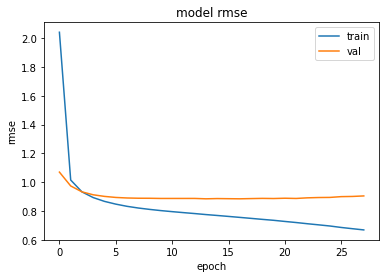

In [48]:
# Plot model rmse

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Build a Full recommender system for Prediction

The system will use the retrieval model to generate a list of movies. Then, the rating models will be used to predict user ratings for these movies. The final recommendation are listed based on the highest 10 rated movies.

In [49]:
def predict_movie(userId, top_n):
    # Use brute-force search to set up retrieval using the trained representations.
    index = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_model)
    index.index_from_dataset(
        movies.batch(100).map(lambda title: (title, retrieval_model.movie_model(title))))
    
    # Get some recommendations
    _, titles = index(np.array([str(userId)]))
    
    print("Top {} recommendations for user {}: \n".format(top_n, userId))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(userId, movie):
    predicted_rating = ranking_model({
        "userId": np.array([str(userId)]),
        "original_title": np.array([movie])
    })
    
    #return predicted_rating
    print("Predicted rating for user {} for movie '{}': {}".format(userId, movie, predicted_rating.numpy()[0][0]))
    
def predict_movie_df(userId):
    # Use brute-force search to set up retrieval using the trained representations.
    index = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_model)
    index.index_from_dataset(
        movies.batch(100).map(lambda title: (title, retrieval_model.movie_model(title))))
    
    # Get some recommendations
    _, titles = index(np.array([str(userId)]))
    
    title_list = []
    for i, title in enumerate(titles[0,:].numpy()):
        title_list.append(title.decode("utf-8"))
        
    # Predicted ratings
    rating_list = []
    for movie in title_list:
        predicted_rating = ranking_model({
        "userId": np.array([str(userId)]),
        "original_title": np.array([movie])
        })
        rating_list.append(predicted_rating.numpy()[0][0])
        
    temp = pd.DataFrame({'original_title': title_list, 'predicted_rating': rating_list})
   
    # Create dataFrame
    predicted_movie_df = df[df['original_title'].isin(title_list)]
    predicted_movie_df = predicted_movie_df[['id', 'original_title', 'genres', 'overview']]
    predicted_movie_df = predicted_movie_df.merge(temp, on='original_title')
    predicted_movie_df = predicted_movie_df.sort_values(by='predicted_rating', ascending=False)
    predicted_movie_df = predicted_movie_df.head(10)
    predicted_movie_df = predicted_movie_df.reset_index(drop=True)
    
    return predicted_movie_df

### Generate unique user and movie lists

In [50]:
user_list = ratings_copy.userId.unique()
movie_list = df.original_title.unique()

In [51]:
user = random.choice(user_list)
movie = random.choice(movie_list)

In [52]:
predict_movie(user, 5)

Top 5 recommendations for user 550: 

1. Addicted to Love
2. Teenage Mutant Ninja Turtles III
3. The Departed
4. Captain Corelli's Mandolin
5. Parenthood


In [53]:
predict_rating(user, movie)

Predicted rating for user 550 for movie 'White Rabbit': 2.22641921043396


## Examining User Input and Prediction 

**User 1**

In [54]:
user1 = random.choice(user_list)

In [55]:
user1_input = ratings_copy[ratings_copy.userId == str(user1)]
user1_input = user1_input[['userId', 'movieId', 'original_title', 'genres', 'overview', 'rating']]
user1_input

,userId,movieId,original_title,genres,overview,rating
41524,644,24,Kill Bill: Vol. 1,"Action, Crime",An assassin is shot at the altar by her ruthle...,3.0
41525,644,235,Stand by Me,"Crime, Drama","After the death of a friend, a writer recounts...",5.0
41526,644,348,Alien,"Horror, Action, Thriller, Science Fiction","During its return to the earth, commercial spa...",5.0
41527,644,527,Once Were Warriors,Drama,A drama about a Maori family lving in Auckland...,5.0
41528,644,608,Men in Black II,"Action, Adventure, Comedy, Science Fiction","Kay and Jay reunite to provide our best, last ...",5.0
41529,644,1247,The Good Shepherd,"Drama, Thriller, History","Edward Wilson, the only witness to his father'...",5.0
41530,644,1836,Dans ma peau,"Drama, Horror","Esther, a self-conscious young woman who works...",5.0
41531,644,1911,The 13th Warrior,"Adventure, Fantasy, Action","In AD 922, Arab courtier, Ahmad Ibn Fadlan acc...",2.0
41532,644,2089,Cutaway,"Action, Thriller",The successful undercover agent Victor Cooper ...,3.0
41533,644,2093,Amsterdamned,"Action, Horror, Thriller",A mysterious diver hiding in Amsterdam's canal...,4.0


In [56]:
predict_movie_df(user1)

,id,original_title,genres,overview,predicted_rating
0,759,Gentlemen Prefer Blondes,"Comedy, Romance",Lorelei Lee is a beautiful showgirl engaged to...,6.050445
1,1361,The Return of the King,"Animation, Family, Fantasy",Two Hobbits struggle to destroy the Ring in Mo...,5.784979
2,1859,Ninotchka,"Comedy, Romance",A stern Russian woman sent to Paris on officia...,5.472972
3,1846,Marlowe,"Crime, Mystery, Drama",Los Angeles private-eye Philip Marlowe is tryi...,5.415763
4,1834,"Murder, My Sweet","Crime, Drama, Mystery, Thriller",Detective Philip Marlowe is hired by hulking M...,4.887545
5,2395,Astérix aux Jeux Olympiques,"Fantasy, Adventure, Comedy, Family",Astérix and Obélix have to win the Olympic Gam...,4.866899
6,1244,Das wilde Leben,"Music, Drama, Comedy",Achim Bornhak's movie focuses on the restless ...,4.816463
7,549,Basquiat,"Drama, History",Director Julian Schnabel illustrates the portr...,4.750045
8,1594,A Shot in the Dark,"Comedy, Crime",A Shot in the Dark is the second and more succ...,4.674579
9,2912,Le Boucher,"Drama, Foreign, Thriller","An unlikely friendship between a dour, working...",4.585292


**User 2**

In [57]:
user2 = random.choice(user_list)

user2_input = ratings_copy[ratings_copy.userId == str(user2)]
user2_input = user2_input[['userId', 'movieId', 'original_title', 'genres', 'overview', 'rating']]
user2_input

,userId,movieId,original_title,genres,overview,rating
22032,370,110,Trois couleurs : Rouge,"Drama, Mystery, Romance",Red This is the third film from the trilogy by...,4.0
22033,370,168,Star Trek IV: The Voyage Home,"Science Fiction, Adventure",Fugitives of the Federation for their daring r...,3.0
22034,370,235,Stand by Me,"Crime, Drama","After the death of a friend, a writer recounts...",4.0
22035,370,260,The 39 Steps,"Action, Thriller, Mystery","While on vacation in London, Canadian Richard ...",4.5
22036,370,288,High Noon,Western,High Noon is about a recently freed leader of ...,4.0
22037,370,318,The Million Dollar Hotel,"Drama, Thriller",The Million Dollar Hotel starts with a jump fr...,5.0
22038,370,329,Jurassic Park,"Adventure, Science Fiction",A wealthy entrepreneur secretly creates a them...,3.0
22039,370,466,Klute,Mystery,This acclaimed thriller stars Jane Fonda as Br...,3.0
22040,370,509,Notting Hill,"Romance, Comedy, Drama",The British comedy from director Roger Michell...,4.0
22041,370,527,Once Were Warriors,Drama,A drama about a Maori family lving in Auckland...,4.0


In [58]:
predict_movie_df(user2)

,id,original_title,genres,overview,predicted_rating
0,2232,Die Legende von Paul und Paula,"Drama, Romance",Paul and Paula have had bad experiences with l...,4.843924
1,2959,License to Wed,Comedy,"Newly engaged, Ben and Sadie can't wait to sta...",4.840959
2,3527,Don't Come Knocking,"Drama, Music",Howard Spence has seen better days. Once a big...,4.419434
3,2502,The Bourne Supremacy,"Action, Drama, Thriller",When a CIA operation to purchase classified Ru...,4.418777
4,3033,Gods and Monsters,Drama,"It's 1957, and Whale's heyday as the director ...",4.417320
5,4105,Black Rain,"Action, Thriller, Crime",Two New York cops get involved in a gang war b...,4.252842
6,97938,Heart of the Country,"Family, Romance, Drama",With her husband jailed for Wall Street-based ...,4.237671
7,2011,Persepolis,"Animation, Drama","In 1970s Iran, Marjane 'Marji' Statrapi watche...",4.131758
8,8961,Bad Boys II,"Adventure, Action, Comedy, Thriller, Crime","Out-of-control, trash-talking buddy cops Marcu...",4.118532
9,1676,Will Penny,"Romance, Western","Will Penny, an aging cowpoke, takes a job on a...",3.820840


**User 3**

In [59]:
user3 = random.choice(user_list)

user3_input = ratings_copy[ratings_copy.userId == str(user3)]
user3_input = user3_input[['userId', 'movieId', 'original_title', 'genres', 'overview', 'rating']]
user3_input

,userId,movieId,original_title,genres,overview,rating
14307,237,110,Trois couleurs : Rouge,"Drama, Mystery, Romance",Red This is the third film from the trilogy by...,1.5
14308,237,153,Lost in Translation,Drama,"Two lost souls visiting Tokyo -- the young, ne...",2.5
14309,237,198,To Be or Not to Be,"Comedy, War","During the Nazi occupation of Poland, an actin...",4.0
14310,237,260,The 39 Steps,"Action, Thriller, Mystery","While on vacation in London, Canadian Richard ...",4.0
14311,237,272,Batman Begins,"Action, Crime, Drama","Driven by tragedy, billionaire Bruce Wayne ded...",4.5
14312,237,292,Dave Chappelle's Block Party,"Comedy, Documentary, Music",The American comedian/actor delivers a story a...,3.5
14313,237,296,Terminator 3: Rise of the Machines,"Action, Thriller, Science Fiction",It's been 10 years since John Connor saved Ear...,4.5
14314,237,316,Halbe Treppe,"Comedy, Drama",In the style of a documentary this tragic come...,2.0
14315,237,318,The Million Dollar Hotel,"Drama, Thriller",The Million Dollar Hotel starts with a jump fr...,4.5
14316,237,329,Jurassic Park,"Adventure, Science Fiction",A wealthy entrepreneur secretly creates a them...,2.5


In [60]:
predict_movie_df(user3)

,id,original_title,genres,overview,predicted_rating
0,318,The Million Dollar Hotel,"Drama, Thriller",The Million Dollar Hotel starts with a jump fr...,4.218070
1,296,Terminator 3: Rise of the Machines,"Action, Thriller, Science Fiction",It's been 10 years since John Connor saved Ear...,4.106395
2,509,Notting Hill,"Romance, Comedy, Drama",The British comedy from director Roger Michell...,3.932504
3,150,48 Hrs.,"Thriller, Action, Comedy, Crime, Drama",A hard-nosed cop reluctantly teams up with a w...,3.496068
4,21,The Endless Summer,Documentary,"The Endless Summer, by Bruce Brown, is one of ...",3.470556
5,590,The Hours,Drama,"""The Hours"" is the story of three women search...",3.273726
6,349,Crustacés et coquillages,Comedy,Crustaces et Coquillages is a fresh French com...,3.093425
7,592,The Conversation,"Crime, Drama, Mystery",Surveillance expert Harry Caul (Gene Hackman) ...,2.949486
8,329,Jurassic Park,"Adventure, Science Fiction",A wealthy entrepreneur secretly creates a them...,2.640841
9,380,Rain Man,Drama,Selfish yuppie Charlie Babbitt's father left a...,2.621474


## Conclusion

In this Notebook, we explored two ways to perform recommendation to customers. First, we built recommender using **tensorflow recommender system (TFRS)**. TFRS is a library for building recommender system models. The advantages of using TFRS are:
1. Build and evaluate flexible recommendation retrieval models.
2. Freely incorporate item, user, and context information into recommendation models.
3. Train multi-task models that jointly optimize multiple recommendation objectives.

Second, we built recommender using **Collaborative-filtering**. Collaborative-filtering uses similarities between users and items simultaneously to provide recommendations. Collaborative filtering models can recommend an item to user A based on the interests of a similar user B. Furthermore, the embeddings can be learned automatically, without relying on hand-engineering of features.

## Addtional Steps

There are more future research can be done followed by this notebook:
1. Explore deeper model for TFRS
2. Explore collaborative-filtering model with more than one user input